In [32]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PyDictionary import PyDictionary

from sklearn.decomposition import PCA
import torch

# from llama import Dialog, Llama

import matplotlib as mpl 
import matplotlib.colors as mcolors
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

In [33]:
with open("inference_dictionary_words_fake.pkl", "rb") as fp:
    rdm_data_no_list = pickle.load(fp)

with open("inference_dictionary_words_real.pkl", "rb") as fp:
    rdm_data_yes_list = pickle.load(fp)

with open("synonyme_inference_dictionary_words_fake.pkl", "rb") as fp:
    data_no_list = pickle.load(fp)

with open("synonyme_inference_dictionary_words_real.pkl", "rb") as fp:
    data_yes_list = pickle.load(fp)



In [34]:
def gather_norm_acts(data):
    list_norm_act = []
    # For each dataset element (words)
    for word_id in range(len(data)):
        list_norm_act.append([])
        # For the subset of selected layers in the dictionaray
        for layer_nb in data[word_id]["hook"].keys():
            list_norm_act[word_id].append(data[word_id]["hook"][layer_nb]["normalized"])
    return list_norm_act

# Selecting last element of the generation - AKA the Yes generation or No generation
yes_act = gather_norm_acts(data_yes_list)
rdm_yes_act = gather_norm_acts(rdm_data_yes_list)
no_act = gather_norm_acts(data_no_list)
rdm_no_act = gather_norm_acts(rdm_data_no_list)

print("Just a list of layer size with each embedding size vector")
print(len(yes_act))          # Size of word dataset
print(len(yes_act[0]))       # Size of layer (subset)
print(len(yes_act[0][0]))    # Size of output
print(len(yes_act[0][0][0])) # Size of enbedding

Just a list of layer size with each embedding size vector
100
32
1
4096


# Retrieving distance for each layer in the model

Needs a list of vectors for each layer in order to perform distance towards vectors.
 
Maybe should rather compile the direction or angular disatnces.

In [35]:
# Distqnce between the prediction given by two different questions

act1 = yes_act[0]
act2 = no_act[0]

distance_matrix = []
for i, layer_act in enumerate(no_act):
    distance_matrix.append([])
    for j, t_fwd in enumerate(layer_act):
        dist = torch.nn.functional.pairwise_distance(yes_act[i][j], no_act[i][j])
        
        distance_matrix[i].append(dist.cpu().item())
# distance_matrix = np.array(distance_matrix)
# distance_matrix = (distance_matrix - distance_matrix.min())/(distance_matrix.max() - distance_matrix.min())
plt.imshow(distance_matrix)
plt.colorbar()
plt.show()

# print(''.join(data_yes_list["hook"][31]["tokens"]))
print(''.join(data_no_list["hook"][0]["tokens"]))

TypeError: pairwise_distance(): argument 'x1' (position 1) must be Tensor, not list

In [36]:
def flat_data(data, words, layers, tokens):
    data = [data[w][l][t] for w in words for l in layers for t in tokens]

    return data

# Creating labels of the existance of words

In [6]:
# Word check
dictionary = PyDictionary()
no_label = []
yes_label = []

def word_exists(word):
    meaning = dictionary.meaning(word)
    return meaning is not None

for i in range(len(data_no_list)):
    input_nature = word_exists(data_no_list[i]["input"])
    output_nature = word_exists(data_no_list[i]["output"])

    print("{}: input {} is {} -> \t \t output {} is {}".format(i, data_no_list[i]["input"], input_nature, data_no_list[i]["output"], output_nature))
    no_label.append([input_nature, output_nature])

for i in range(len(data_yes_list)):
    input_nature = word_exists(data_yes_list[i]["input"])
    output_nature = word_exists(data_yes_list[i]["output"])

    print("{}: input {} is {} -> \t \t output {} is {}".format(i, data_yes_list[i]["input"], input_nature, data_yes_list[i]["output"], output_nature))
    yes_label.append([input_nature, output_nature])

Error: The Following Error occured: list index out of range
0: input Blorble is False -> 	 	 output Fusion is True
Error: The Following Error occured: list index out of range
1: input Flynth is False -> 	 	 output Thunder is True
Error: The Following Error occured: list index out of range
2: input Quindle is False -> 	 	 output Sprint is True
Error: The Following Error occured: list index out of range
3: input Wimbish is False -> 	 	 output Fog is True
Error: The Following Error occured: list index out of range
4: input Trindle is False -> 	 	 output Fusion is True
Error: The Following Error occured: list index out of range
5: input Flaxet is False -> 	 	 output Frost is True
Error: The Following Error occured: list index out of range
6: input Snorfle is False -> 	 	 output Kite is True
Error: The Following Error occured: list index out of range
7: input Glimmeron is False -> 	 	 output Diamond is True
Error: The Following Error occured: list index out of range
8: input Jorkle is False

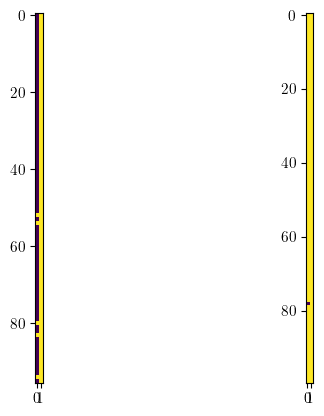

In [37]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.array(no_label));
# ax[0].title("labels of the fake word generation")
ax[1].imshow(np.array(yes_label))
# ax[1].title("labels of the real word generation")

plt.show()

In [38]:
# color_selction = ["gold", "orange", "pink", "purple"]
color_selction = ["#ef6c00", "#eeff41", "#009668", "#ce93d8" , "#a1e8d9", "#b3a77d", "#6a634a"]

def simple_label2color(label):
    # labels are 4 choices
    color = color_selction[label]
    return color

def bidim_label2color(label):
    # labels are 2*2*2 choices
    color = color_selction[label[1] + 2*label[2]]
    # color = mcolors.CSS4_COLORS[color_selction[label[1] + 2*label[2]]]
    return color

In [39]:
layer_nb = 16

# Gather the list correctly
no_states = flat_data(no_act, range(len(no_act)), [layer_nb], [-1])
no_states = torch.stack(no_states)
yes_states = flat_data(yes_act, range(len(yes_act)), [layer_nb], [-1])
yes_states = torch.stack(yes_states)
rdm_no_states = flat_data(rdm_no_act, range(len(rdm_no_act)), [layer_nb], [-1])
rdm_no_states = torch.stack(rdm_no_states)
rdm_yes_states = flat_data(rdm_yes_act, range(len(rdm_yes_act)), [layer_nb], [-1])
rdm_yes_states = torch.stack(rdm_yes_states)


print(no_states.shape)
print(yes_states.shape)
print(rdm_no_states.shape)
print(rdm_yes_states.shape)

torch.Size([96, 4096])
torch.Size([100, 4096])
torch.Size([96, 4096])
torch.Size([100, 4096])


# Test Data according to veracity of Input-Output words

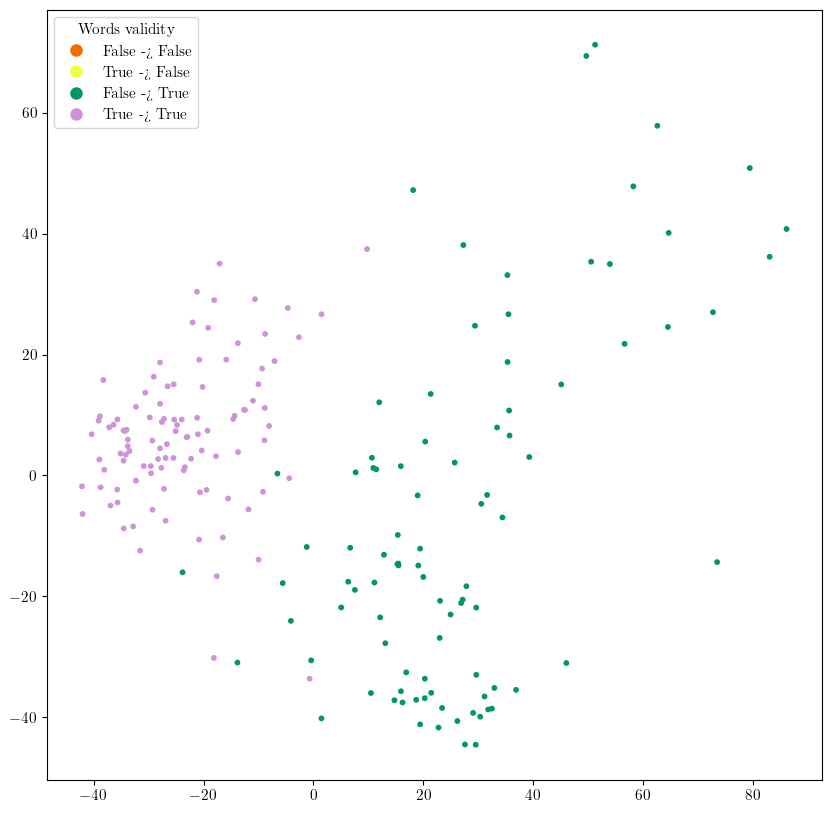

In [40]:
bi_label_colors = [bidim_label2color([0, no_label[i][0], no_label[i][1]]) for i in range(len(no_states))] + [bidim_label2color([1, yes_label[i][0], yes_label[i][1]]) for i in range(len(yes_states))] 

layer_nb = 16

# Gather the list correctly
no_states = flat_data(no_act, range(len(no_act)), [layer_nb], [-1])
no_states = torch.stack(no_states)
yes_states = flat_data(yes_act, range(len(yes_act)), [layer_nb], [-1])
yes_states = torch.stack(yes_states)

X = np.concatenate([no_states.type(torch.float64).cpu().numpy(), yes_states.type(torch.float64).cpu().numpy()])

pca = PCA(n_components=2)
x = pca.fit_transform(X)

plt.figure(figsize=(10, 10), dpi=100)
scatter = plt.scatter(x[:, 0], x[:, 1], c=bi_label_colors, s=10)

legend_labels = ["False -> False", "True -> False", "False -> True", "True -> True"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("Conterexemple_random_generation")
plt.show()

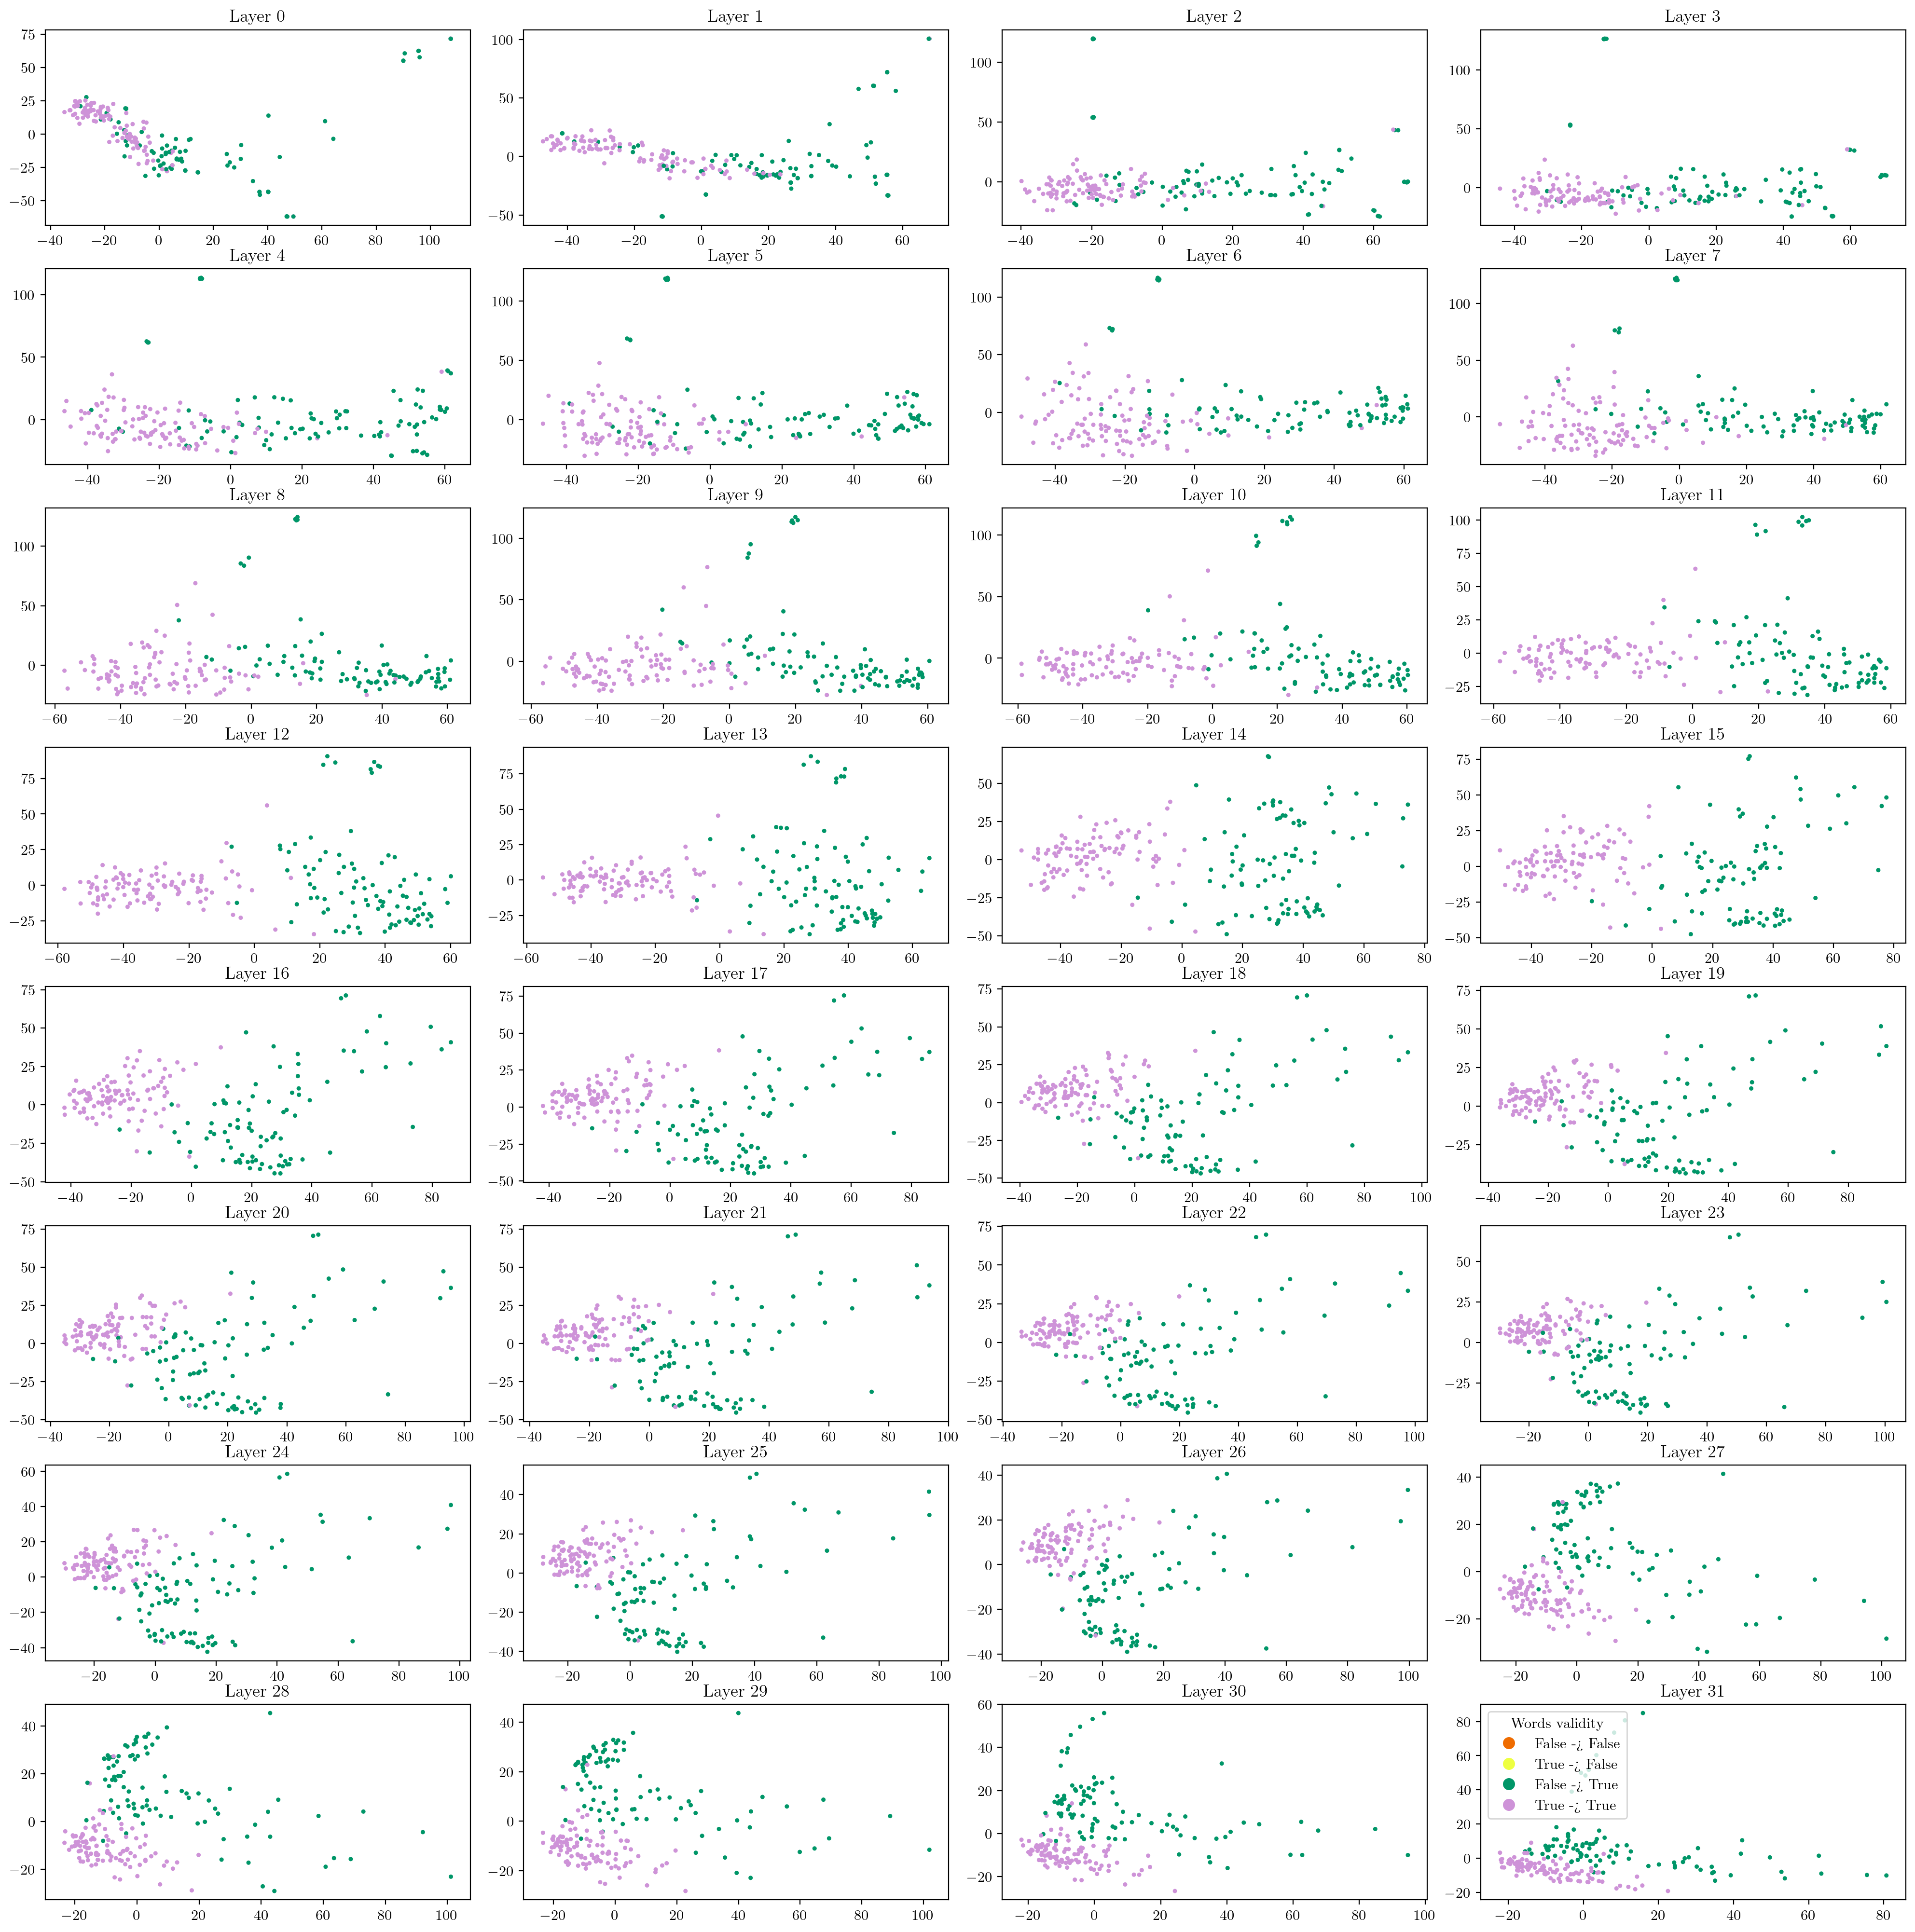

In [41]:
fig, ax = plt.subplots(8,4, figsize=(20, 20), dpi=200)

fig.tight_layout()

for layer_nb in range(32):

    # Gather the list correctly
    no_states = flat_data(no_act, range(len(no_act)), [layer_nb], [-1])
    no_states = torch.stack(no_states)
    yes_states = flat_data(yes_act, range(len(yes_act)), [layer_nb], [-1])
    yes_states = torch.stack(yes_states)

    X = np.concatenate([no_states.type(torch.float64).cpu().numpy(), yes_states.type(torch.float64).cpu().numpy()])

    pca = PCA(n_components=2)
    x = pca.fit_transform(X)

    ax[layer_nb//4][layer_nb%4].scatter(x[:, 0], x[:, 1], c=bi_label_colors, s=5)
    ax[layer_nb//4][layer_nb%4].set_title("Layer {}".format(layer_nb))

legend_labels = ["False -> False", "True -> False", "False -> True", "True -> True"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("Conterexemple_random_generation_multilayer")
plt.show()

# Test comparaison of data process: Random word generation Vs 2 task choice

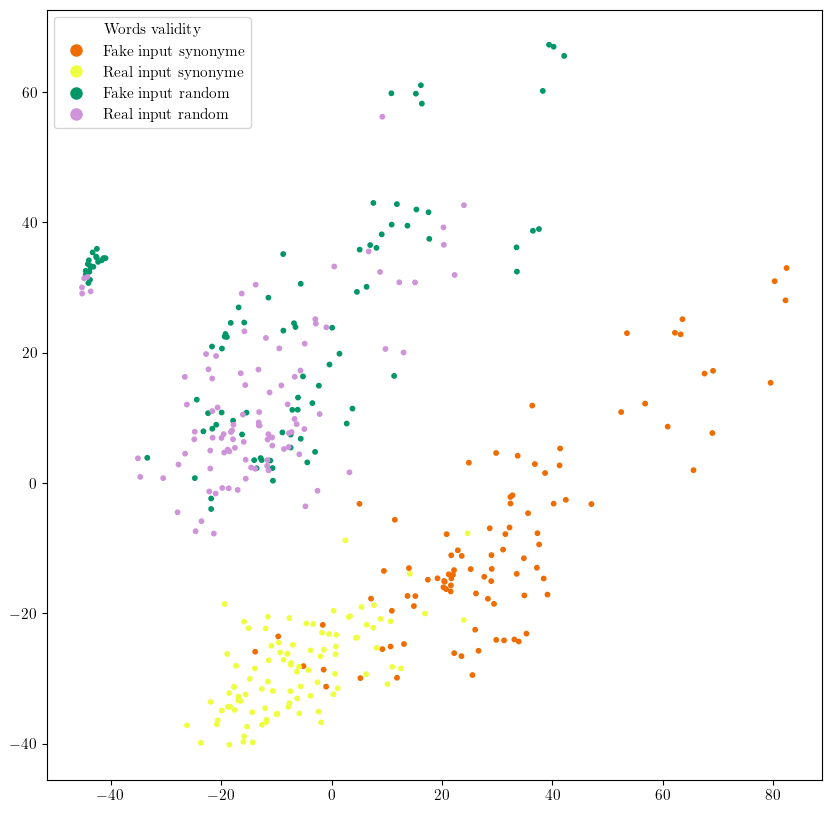

In [51]:
label_colors = [simple_label2color(0) for _ in range(len(no_states))] + [simple_label2color(1) for _ in range(len(yes_states))] + [simple_label2color(2) for _ in range(len(rdm_no_states))] + [simple_label2color(3) for _ in range(len(rdm_yes_states))]

layer_nb = 16

# Gather the list correctly
no_states = flat_data(no_act, range(len(no_act)), [layer_nb], [-1])
no_states = torch.stack(no_states)
yes_states = flat_data(yes_act, range(len(yes_act)), [layer_nb], [-1])
yes_states = torch.stack(yes_states)
rdm_no_states = flat_data(rdm_no_act, range(len(rdm_no_act)), [layer_nb], [-1])
rdm_no_states = torch.stack(rdm_no_states)
rdm_yes_states = flat_data(rdm_yes_act, range(len(rdm_yes_act)), [layer_nb], [-1])
rdm_yes_states = torch.stack(rdm_yes_states)

X = np.concatenate([no_states.type(torch.float64).cpu().numpy(), yes_states.type(torch.float64).cpu().numpy(), rdm_no_states.type(torch.float64).cpu().numpy(), rdm_yes_states.type(torch.float64).cpu().numpy()])

pca = PCA(n_components=2)
x = pca.fit_transform(X)

plt.figure(figsize=(10, 10), dpi=100)
scatter = plt.scatter(x[:, 0], x[:, 1], c=label_colors, s=10)

legend_labels = ["Fake input synonyme", "Real input synonyme", "Fake input random", "Real input random"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("Random_and_2double_task_layer16.png")
plt.show()

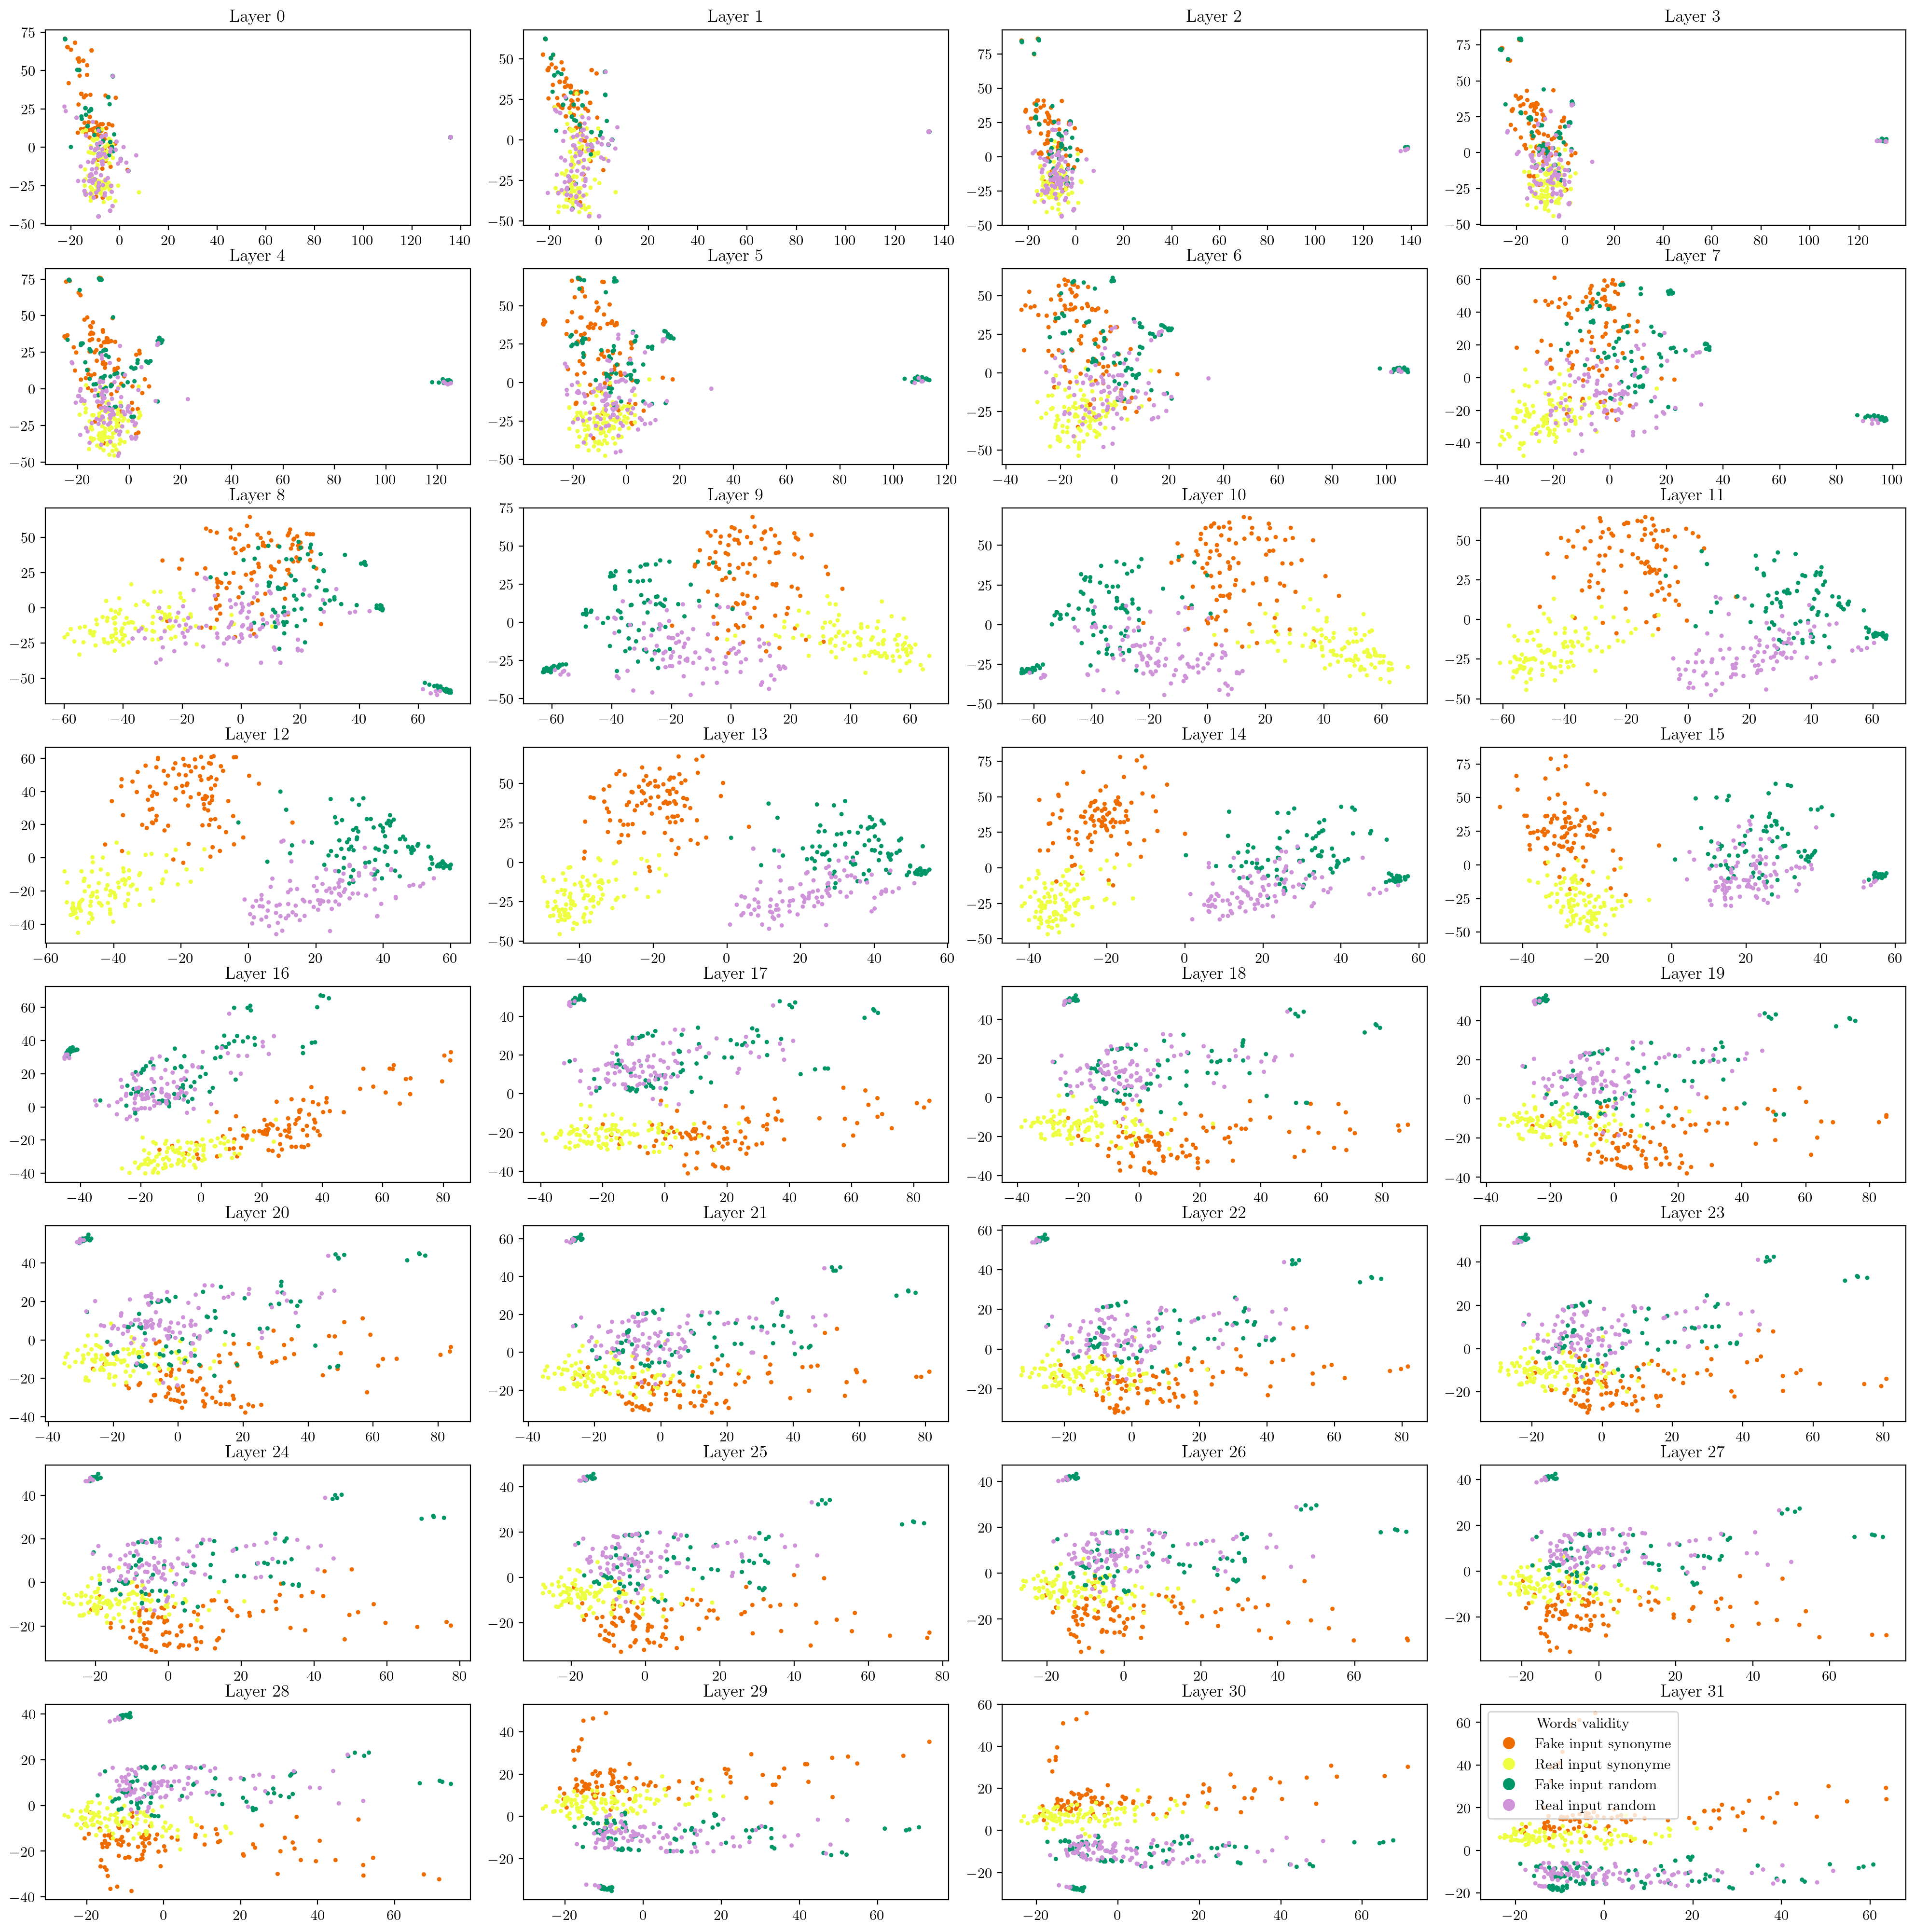

In [52]:
fig, ax = plt.subplots(8,4, figsize=(20, 20), dpi=200)

fig.tight_layout()

for layer_nb in range(32):

    # Gather the list correctly
    no_states = torch.stack(flat_data(no_act, range(len(no_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    yes_states = torch.stack(flat_data(yes_act, range(len(yes_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    rdm_no_states = torch.stack(flat_data(rdm_no_act, range(len(rdm_no_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    rdm_yes_states = torch.stack(flat_data(rdm_yes_act, range(len(rdm_yes_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()

    X = np.concatenate([no_states, yes_states, rdm_no_states, rdm_yes_states])

    pca = PCA(n_components=4)
    x = pca.fit_transform(X)

    ax[layer_nb//4][layer_nb%4].scatter(x[:, 0], x[:, 1], c=label_colors, s=5)
    ax[layer_nb//4][layer_nb%4].set_title("Layer {}".format(layer_nb))

legend_labels = ["Fake input synonyme", "Real input synonyme", "Fake input random", "Real input random"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("Random_and_2double_task_multilayer.png")
plt.show()

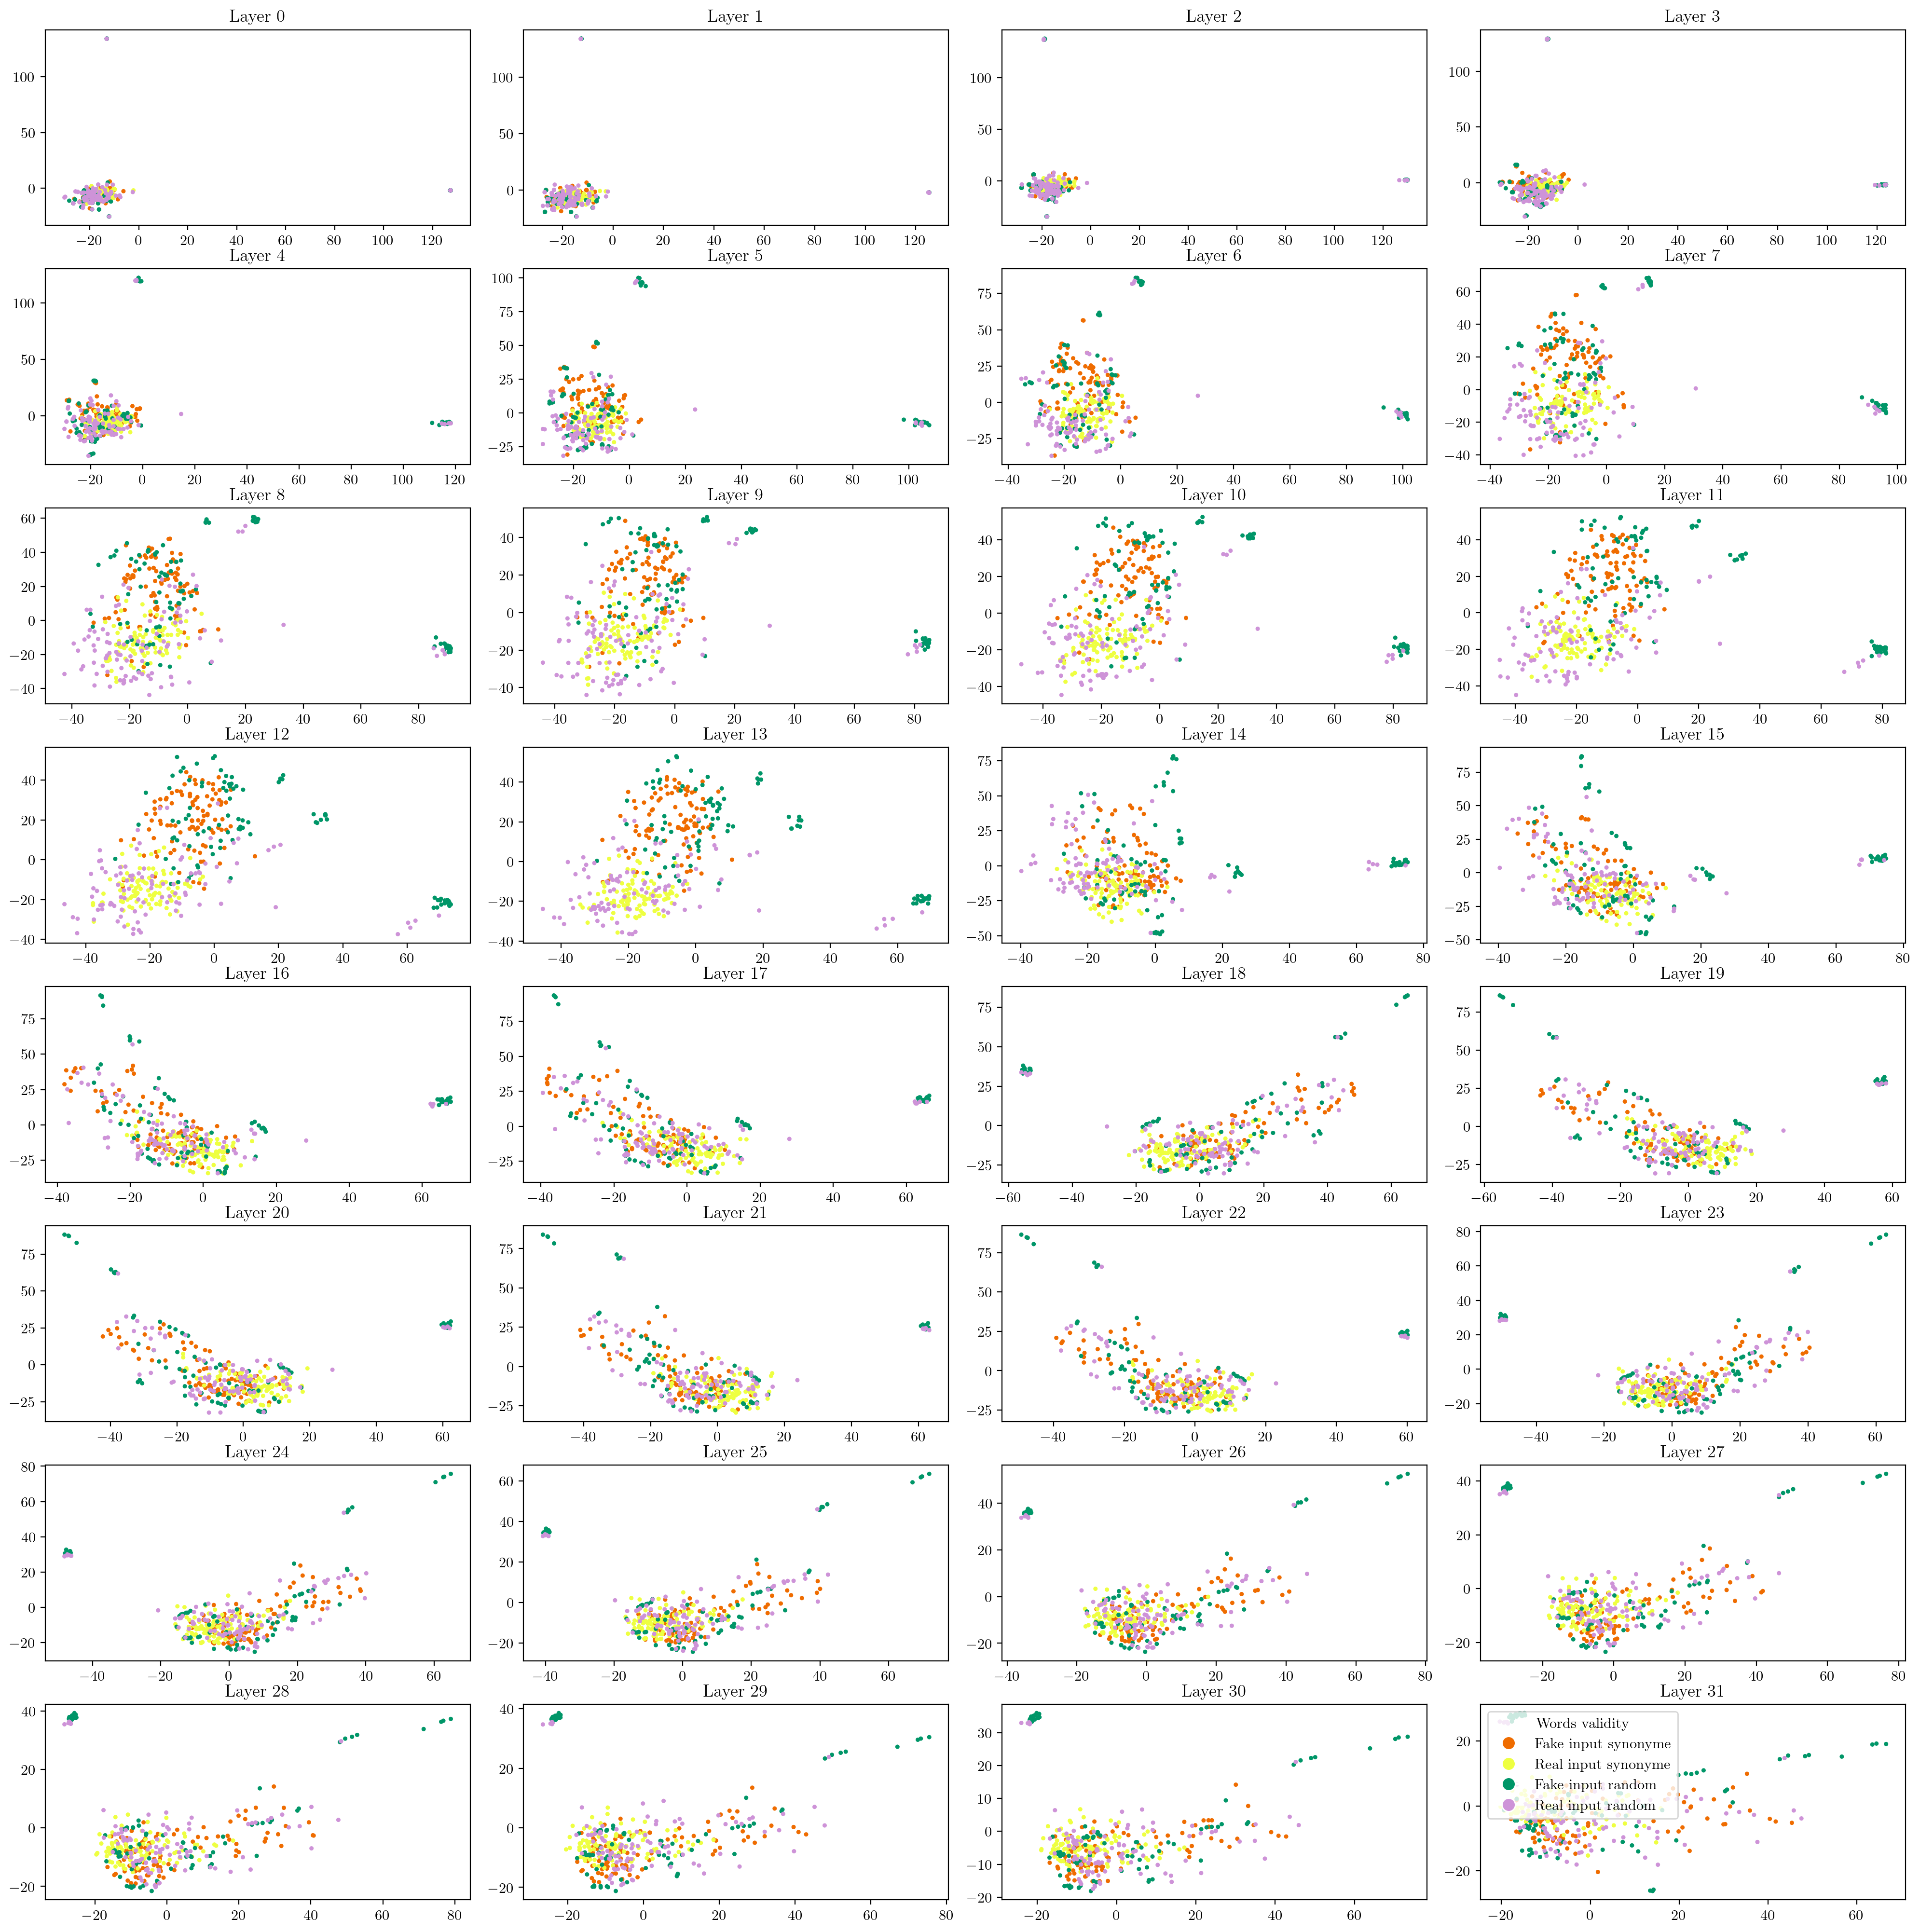

In [57]:
fig, ax = plt.subplots(8,4, figsize=(20, 20), dpi=200)

fig.tight_layout()

for layer_nb in range(32):

    # Gather the list correctly
    no_states = torch.stack(flat_data(no_act, range(len(no_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    yes_states = torch.stack(flat_data(yes_act, range(len(yes_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    rdm_no_states = torch.stack(flat_data(rdm_no_act, range(len(rdm_no_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    rdm_yes_states = torch.stack(flat_data(rdm_yes_act, range(len(rdm_yes_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()


    pca = PCA(n_components=4)
    # Fit only with the non random data
    pca.fit(np.concatenate([rdm_no_states, rdm_yes_states]))
    X = np.concatenate([no_states, yes_states, rdm_no_states, rdm_yes_states])
    # Transform all the data
    x = pca.transform(X)

    ax[layer_nb//4][layer_nb%4].scatter(x[:, 0], x[:, 1], c=label_colors, s=5)
    ax[layer_nb//4][layer_nb%4].set_title("Layer {}".format(layer_nb))

legend_labels = ["Fake input synonyme", "Real input synonyme", "Fake input random", "Real input random"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("rdm_gen_PCA_applied_2double_task_multilayer.png")
plt.show()